## BBC Experiment

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fastai.vision import *
from pathlib import Path
import pandas as pd

In [3]:
path=Path('../data/bbc_train')

In [4]:
path.ls()

[PosixPath('../data/bbc_train/images'),
 PosixPath('../data/bbc_train/classification_labels.csv'),
 PosixPath('../data/bbc_train/bboxes.json'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/masks')]

In [5]:
labels=pd.read_csv(path/'classification_labels.csv')

In [6]:
labels.head()

,filename,label,label_index
0,P2050936.jpg,ball,2
1,P2050922.jpg,ball,2
2,P2060163.jpg,brick,1
3,P2060003.jpg,ball,2
4,P2060017.jpg,ball,2


In [7]:
data= ImageDataBunch.from_df(path=path/'images', df=labels, valid_pct=0.2, fn_col='filename', label_col='label', 
                            ds_tfms=get_transforms(), size=256, bs=64).normalize(imagenet_stats)

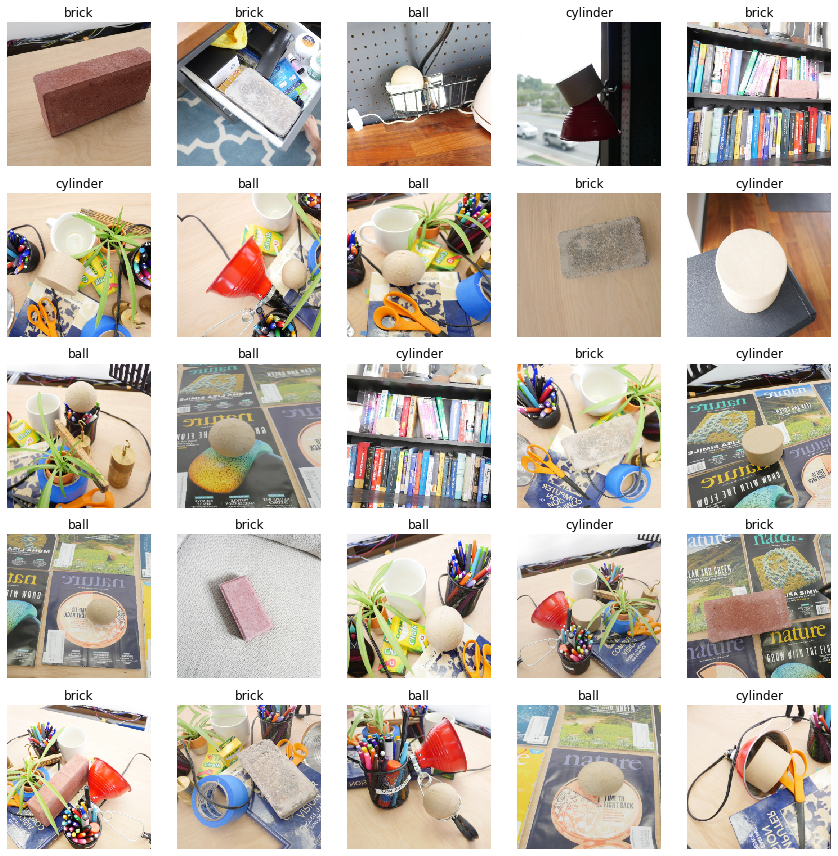

In [8]:
data.show_batch(figsize=(12,12))

In [11]:
learn=cnn_learner(data, models.squeezenet1_0, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /home/ubuntu/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth
100%|██████████| 4.79M/4.79M [00:00<00:00, 114MB/s]


In [12]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [13]:
x,y = learn.data.one_batch()

In [14]:
x.shape, y.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64]))

In [15]:
y

tensor([1, 0, 1, 1, 0, 0, 2, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 2, 1, 2, 0, 2, 0, 1, 0, 1, 1, 0, 2, 2])

In [16]:
y.dtype

torch.int64

- Ok, that's interesting.

- I think loading those full size images is a bit slow, let's consider staging smaller ones!

In [17]:
learn.freeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


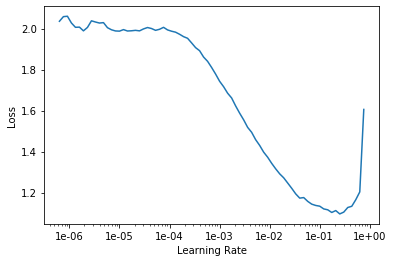

In [19]:
learn.recorder.plot()

In [20]:
lr=5e-3
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.155138,0.444599,0.867021,00:10
1,0.702842,0.232161,0.925532,00:09
2,0.528585,0.198160,0.930851,00:09
3,0.422784,0.168011,0.941489,00:08


In [24]:
learn.export('/home/ubuntu/deep_learning_for_computer_vision/sample_models/export.pkl')

In [28]:
# load_learner('/home/ubuntu/deep_learning_for_computer_vision/sample_models')

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


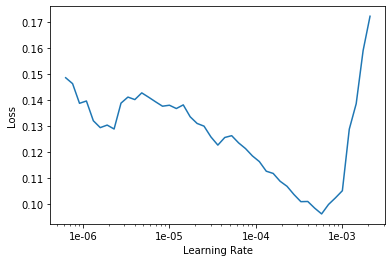

In [16]:
learn.recorder.plot()

In [17]:
lr=1e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.163213,0.066466,0.973404,00:12
1,0.156010,0.061839,0.968085,00:12
2,0.126102,0.051756,0.973404,00:12
3,0.103600,0.016169,0.994681,00:11
4,0.079898,0.013595,0.994681,00:11
5,0.072133,0.019308,0.994681,00:12
6,0.063701,0.022734,0.994681,00:11
7,0.055895,0.023546,0.989362,00:11


In [19]:
interp=ClassificationInterpretation.from_learner(learn)

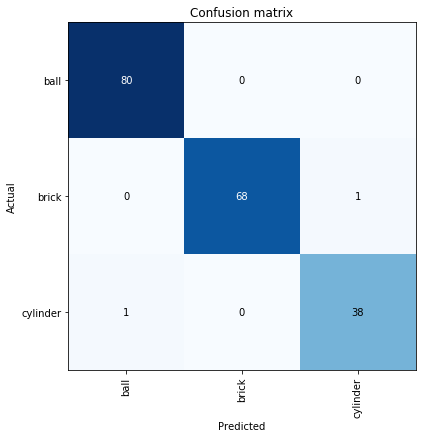

In [27]:
interp.plot_confusion_matrix(figsize=(6,6))

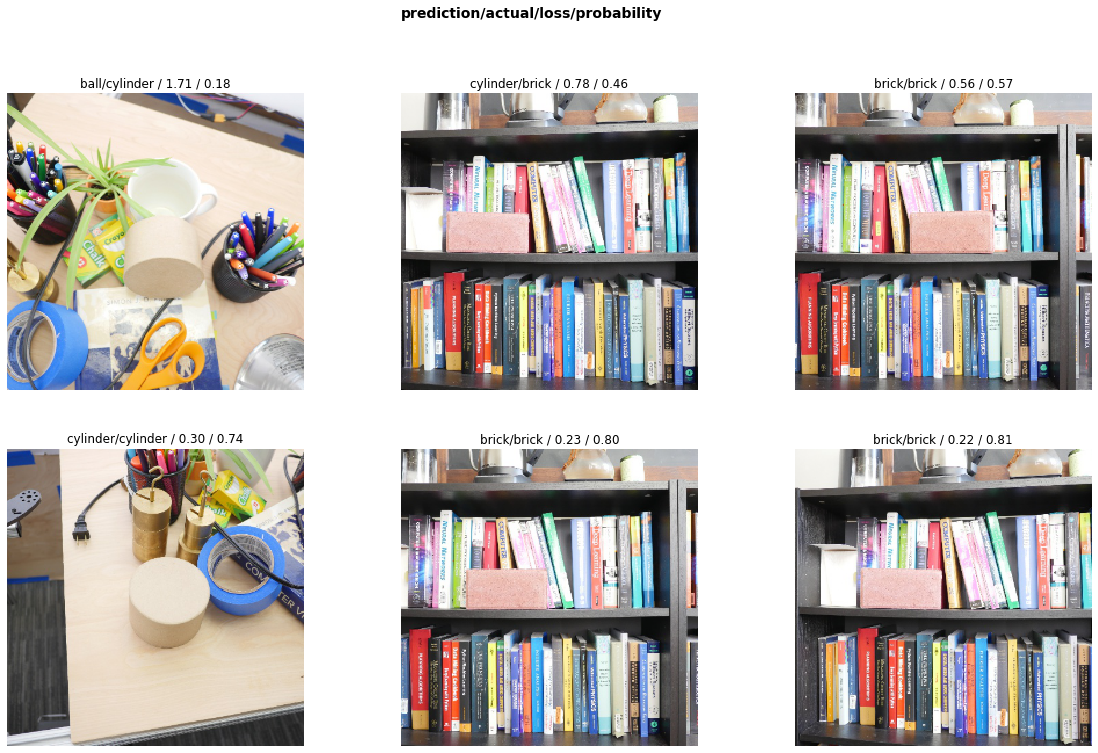

In [31]:
interp.plot_top_losses(k=6, figsize=(20, 12))

## Object Detection

In [119]:
import json

In [120]:
labels=json.load(open(path/'train.json', 'r'))

In [121]:
labels.keys()

dict_keys(['images', 'annotations', 'type', 'categories'])

In [122]:
labels['annotations'][12]['bbox']

[282.39102564102564, 174.0, 70.19230769230762, 67.62820512820511]

In [123]:
images, lbl_bbox = get_annotations(path/'train.json')

In [124]:
images[:5]

['P2050936.jpg',
 'P2050922.jpg',
 'P2060163.jpg',
 'P2060003.jpg',
 'P2060017.jpg']

In [125]:
lbl_bbox[0]

[[[145.47435897435898,
   254.82692307692304,
   237.14102564102564,
   347.4551282051282]],
 ['ball']]

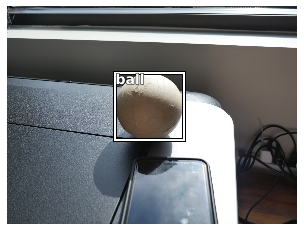

In [126]:
i=30
img = open_image(path/'train'/images[i])
bbox = ImageBBox.create(*img.size, lbl_bbox[i][0], [0], classes=['ball'])
img.show(figsize=(6,4), y=bbox)

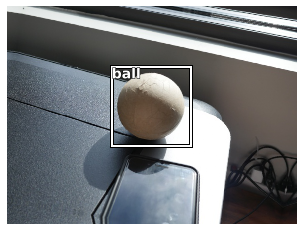

In [127]:
img = img.rotate(-10)
bbox = bbox.rotate(-10)
img.show(figsize=(6,4), y=bbox)

- Cool!

In [128]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [129]:
src = ObjectItemList.from_folder(path/'train')

In [141]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'train')
    src = src.split_by_rand_pct(0.2)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(max_rotate=0), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [142]:
data = get_data(64,128)

In [143]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: ../data/bbc/train;

Valid: LabelList (188 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: ../data/bbc/train;

Test: None

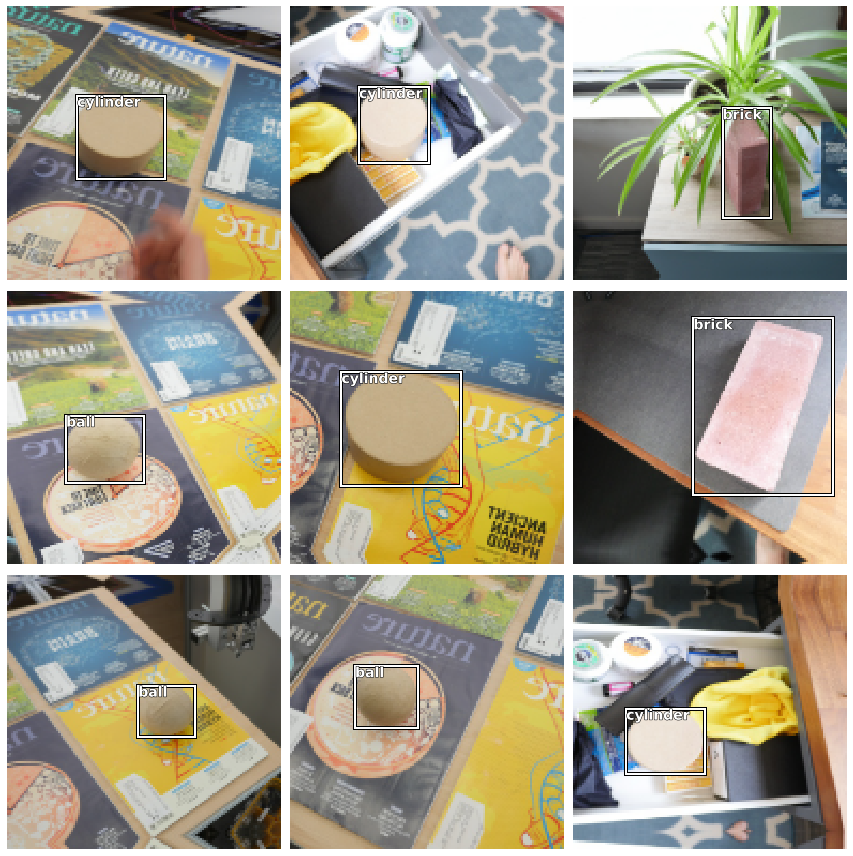

In [145]:
data.show_batch(rows=3)

I can has learner with custom head?

In [218]:
class MyLoss(nn.Module):
    def forward(self, output, bbox_tgts, class_tgts):
        return nn.L1Loss()(output.unsqueeze_(dim=1), bbox_tgts)

In [219]:
custom_head = nn.Sequential(Flatten(), nn.Linear(8192, 4))

In [220]:
learn=cnn_learner(data, models.resnet34, custom_head=custom_head, loss_func=MyLoss())

In [221]:
learn.freeze()

In [211]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


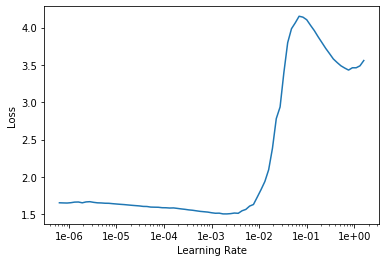

In [212]:
learn.recorder.plot()

In [222]:
lr=1e-4
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,1.653666,1.502828,00:08
1,1.546066,1.327390,00:07
2,1.473359,1.318814,00:07
3,1.413517,1.304678,00:07


In [214]:
learn.unfreeze()

In [215]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


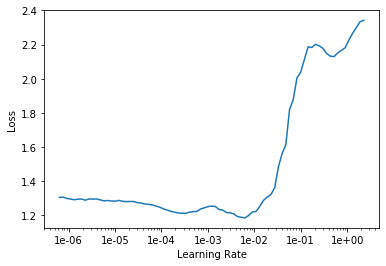

In [216]:
learn.recorder.plot()

In [223]:
lr=1e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,1.299623,1.300660,00:07
1,1.259554,1.243023,00:07
2,1.234340,1.171744,00:07
3,1.205267,1.131191,00:08
4,1.177660,1.100156,00:08
5,1.140453,1.081105,00:07
6,1.121175,1.075754,00:07
7,1.104918,1.072687,00:07


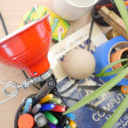

In [229]:
learn.data.train_ds[0][0]

In [230]:
x, y = learn.data.one_batch()

In [233]:
learn.model(x.to('cuda')

SyntaxError: unexpected EOF while parsing (<ipython-input-233-8bcf59f9f0e1>, line 1)

In [239]:
learn.data

AttributeError: 'Tensor' object has no attribute 'apply_tfms'

In [237]:
img,target = next(iter(data.valid_dl))
# with torch.no_grad():
#     output = learn.model(img)

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    x = x.apply_tfms(self.tfms, **self.tfmargs)
AttributeError: 'Tensor' object has no attribute 'apply_tfms'


In [236]:
target

NameError: name 'target' is not defined

In [186]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [187]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
___________________________________________________

In [188]:
learn.loss_func

MyLoss()

- Hmmmm, ok...

In [194]:
x,y =learn.data.one_batch()

In [195]:
x.shape

torch.Size([64, 3, 128, 128])

In [196]:
len(y)

2

In [197]:
y[0].shape, y[1].shape

(torch.Size([64, 1, 4]), torch.Size([64, 1]))

In [199]:
yhat=learn.model(x.to('cuda'))

In [202]:
yhat.unsqueeze_(1).shape

torch.Size([64, 1, 4])

- Hmmmm - how to handle this...Definitley good fastai practice!
- What's the fastai way to handle this - I guess either take it out of the data loader or modify the loss function?
- I feel like not having it in the dataloader is probalby the way to go?
- Hey it would also be interesting to **use the same exact network I used in classification**, so it would be like pretrained on classification.